# Differential rhytmicity analysis of omics datasets

The aim of this tutorial is to use the cosinor_lite Python package to perform differential rhythmicity analysis on omics data. Here we will use published RNA-seq data, but in theory any types of omics data (RNA-seq, proteomics, metabolomics, lipidomics) could be used. The dataset is from the following publication:

Petrenko V, Saini C, Giovannoni L, Gobet C, Sage D, Unser M, Heddad Masson M, Gu G, Bosco D, Gachon F, Philippe J, Dibner C. 2017. Pancreatic α- and β-cellular clocks have distinct molecular properties and impact on islet hormone secretion and gene expression. Genes Dev 31:383–398. doi:10.1101/gad.290379.116


### How does the method actually work?

The details of the method are nicely explained in the article: 

Pelikan A, Herzel H, Kramer A, Ananthasubramaniam B. 2022. Venn diagram analysis overestimates the extent of circadian rhythm reprogramming. The FEBS Journal 289:6605–6621. doi:10.1111/febs.16095

Here is an adaptation of their figure explaining the methdology:

<div style="text-align: center;">
  <img src="../images/model_selection.png" alt="Model selection" style="width:60%;"/>
</div>

For condition 1 (i.e. alpha cells) and condition 2 (i.e. beta cells), we fit 5 different models:

- Model 1) Arrhythmic in alpha and beta cells

- Model 2) Rhythmic in beta cells only

- Model 3) Rhythmic in alpha cells only

- Model 4) Rhythmic in alpha and beta cells with the same rhythmic parameters (i.e. phase and amplitude)

- Model 5) Rhythmic in both but with differential rhythmicity in alpha vs beta cells

A degree of confidence is calculated for each model (called model weight, which sums to 1 across all models), and a model is chosen if the model weight exceeds a threshold (for this tutorial we will use 0.5). If no model exceeds this threshold, then the model is unclassified, which we define as Model 0

- Model 0) unclassified

Let's start running the code to make things more concrete! First we need to load the required packages.

In [1]:
from cosinor_lite.datasets import OmicsDataset
from cosinor_lite.differential_rhytmicity_omics import DifferentialRhythmicity, OmicsHeatmap, TimeSeriesExample
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams.update(
    {
        "font.size": 8,
        "axes.titlesize": 8,
        "axes.labelsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "figure.titlesize": 8,
        "pdf.fonttype": 42,
    },
)
plt.style.use("seaborn-v0_8-ticks")

## Load data

Next, we load in the omics dataset

In [2]:
file: Path = Path.cwd().parent / "data" / "GSE95156_Alpha_Beta.txt"

df_rna: pd.DataFrame = pd.read_csv(file, sep="\t")
df_rna: pd.DataFrame = df_rna.drop(df_rna.columns[0], axis=1)

## Defining sample conditions and times

Typically in omics datasets, each row represents a different entity (gene/protein/lipid etc.), and each samples are stored as separate column.

We need to tell the algorithm the names of the samples corresponding to condition 1 and 2, as well as the corresponding times.

In [3]:
df_rna["Genes"] = df_rna["gene_name"].str.split("|").str[1]

columns_cond1: list[str] = [
    "ZT_0_a_1",
    "ZT_4_a_1",
    "ZT_8_a_1",
    "ZT_12_a_1",
    "ZT_16_a_1",
    "ZT_20_a_1",
    "ZT_0_a_2",
    "ZT_4_a_2",
    "ZT_8_a_2",
    "ZT_12_a_2",
    "ZT_16_a_2",
    "ZT_20_a_2",
]

columns_cond2: list[str] = [
    "ZT_0_b_1",
    "ZT_4_b_1",
    "ZT_8_b_1",
    "ZT_12_b_1",
    "ZT_16_b_1",
    "ZT_20_b_1",
    "ZT_0_b_2",
    "ZT_4_b_2",
    "ZT_8_b_2",
    "ZT_12_b_2",
    "ZT_16_b_2",
    "ZT_20_b_2",
]

t_cond1: np.ndarray = np.array(
    [
        0,
        4,
        8,
        12,
        16,
        20,
        0,
        4,
        8,
        12,
        16,
        20,
    ],
)

t_cond2: np.ndarray = t_cond1.copy()

## Processing the data and visualising the distribution of expression

We next load the data and create a plot of the distribution of all expression values.

In some cases there will be a bimodal distribution, with one large peak at high values and a second, typically smaller peak at very low values. This can be a sign that the small peak at low values represents noise and can be considered as unexpressed.

8.0


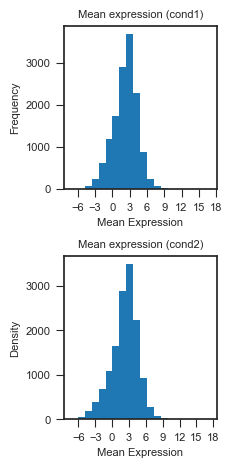

In [4]:
rna_data: OmicsDataset = OmicsDataset(
    df=df_rna,
    columns_cond1=columns_cond1,
    columns_cond2=columns_cond2,
    t_cond1=t_cond1,
    t_cond2=t_cond2,
    deduplicate_on_init=True,
)
rna_data.expression_histogram()

## Quality control

Another basic technique for quality control is to create a scatterplot of technical replicates

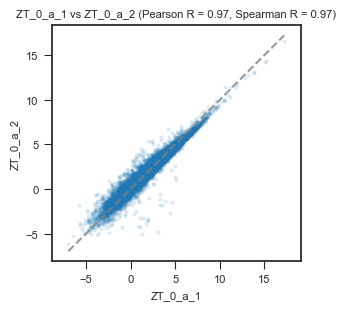

In [5]:
rna_data.replicate_scatterplot(sample1="ZT_0_a_1", sample2="ZT_0_a_2")

In some cases this may reveal that measurements below a certain threshold look visually less correlated between samples. Here we will defines genes as non-expressed using the threshold of <0, as used in the original 2017 article.

In [6]:
rna_data.add_is_expressed(mean_min=0)

## Fitting rhythmic models to the omics dataset

Now things get exciting! We can finally start fitting the rhythmic models to the data. The output of calling DifferentialRhythmicity().extract_all_circadian_params() is a dataframe that contains the model weights across the 5 different models, as well as the amplitude and phase from the selected model for each condition. This can take some time (~5 mins), so go and get a coffee!

In [7]:
dr = DifferentialRhythmicity(dataset=rna_data)
rhythmic_all = dr.extract_all_circadian_params()

Fitting models to genes expressed in both conditions: 100%|██████████| 11147/11147 [07:37<00:00, 24.39it/s]
Fitting models to genes expressed in cond2 only: 100%|██████████| 478/478 [00:04<00:00, 105.43it/s]


## Heatmap of model selection

We can display the results as a heatmap, where we'll visualise models 2-5 using z-scores for each sample.

Note that genes expressed that are only expressed in one condition are given the subclass "a", while genes that are expressed in both conditions are given the subclass "b".

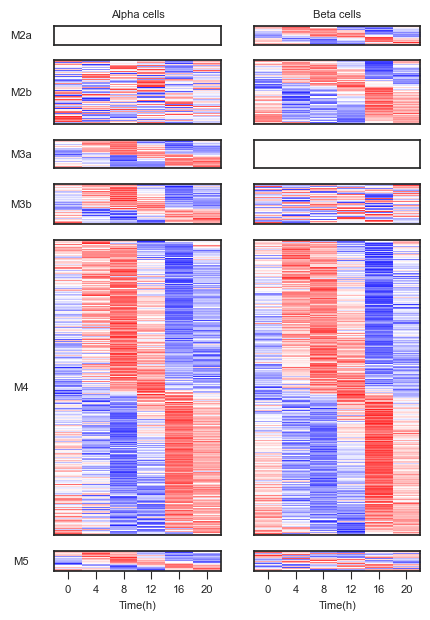

In [8]:
heatmap: OmicsHeatmap = OmicsHeatmap(
    df=rhythmic_all,
    columns_cond1=columns_cond1,
    columns_cond2=columns_cond2,
    t_cond1=t_cond1,
    t_cond2=t_cond2,
    cond1_label="Alpha cells",
    cond2_label="Beta cells",
    show_unexpressed=False,
)
heatmap.plot_heatmap()

## Showing individual examples

Finally, we can manually select genes of interest to show the underlying data (as points) and the fitted cosinor models from the selected model.

Fitting model 2
(<cosinor_lite.differential_rhytmicity_omics.M1OneCondition object at 0x13243f4d0>, <cosinor_lite.differential_rhytmicity_omics.MOscOneCondition object at 0x13243f510>)


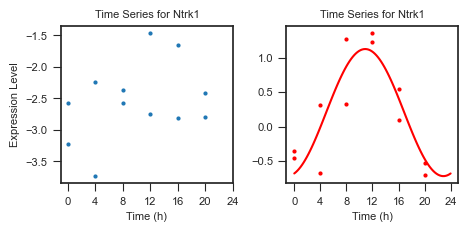

In [9]:
example = TimeSeriesExample(
    df=rhythmic_all,
    columns_cond1=columns_cond1,
    columns_cond2=columns_cond2,
    t_cond1=t_cond1,
    t_cond2=t_cond2,
    cond1_label="Alpha cells",
    cond2_label="Beta cells",
)

# example.plot_time_series("Scg2", xticks=np.arange(0, 25, 4))
# example.plot_time_series("Upk3a", xticks=np.arange(0, 25, 4))
# example.plot_time_series("Kcnk3", xticks=np.arange(0, 25, 4))

example.plot_time_series("Ntrk1", xticks=np.arange(0, 25, 4))